### Clustering and Random Forest models to predict donated value 
This notebook applies statistical analysis, non-linear models, and evaluation metrics to a sample of supporters from the lapsed cash audience who responded to a fixed prompt cash ask.     

The data has been prepared in the jupyter notebook "3b Cash donations exploratory analysis" and imported as a CSV here.  

<font color = orange> Nb this dataset includes outliers, unlike the dataset used for the regression analysis where they were removed.  </font>

Initially my thinking was to use a clustering technique to turn donated values into classifications, and then build a random forest to predict donated value to cash appeals.  You'll see as a I progress through this notebook that clustering wasn't required and random forests can handle continuous and categorical outcomes.



In [1]:
import pandas as pd 
import numpy as np 
df = pd.read_csv('//file path/K037_fixed_cash_cleaned_wOutlier.csv')


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import datasets, neighbors, metrics


In [2]:
df.head().T#ranspose

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
donatedamount,10,63,10,20,50
audienceprofile2016,Upwardly Urban,Not in target,Not in target,Rapid Responders,Unclassified
fixedprompt,20,20,20,20,20
oneoffavgdonatedlast24m,8.3333,25,0,30,30
oneoffdonationsl24m,4,3,1,2,4
everpledgeflag,0,0,1,0,0
lastdonationemer,1,0,0,1,1
alldonationsavgl24m,8.75,26.6666,10.2941,25,35
oneoffltv,64,700,15,517,245


In [3]:
## Tidying up the data... 

##Exporting to CSV copied the pandas index field which isn't needed
df.drop('Unnamed: 0', axis = 1, inplace = True)

# converting binary flags from float to int 
df.everpledgeflag = df['everpledgeflag'].astype(int)
df.lastoneoffga = df['lastoneoffga'].astype(int)

# Found some nulls and filling them with 0
df.lastdonationemer.isnull().sum()
df['lastdonationemer'] = df['lastdonationemer'].fillna(0)
df['lastdonationemer'] = df['lastdonationemer'].astype(int)

## Combining fields to see if these are more powerful than their individual parts
df['pct_last_to_avg24m'] = df.lastoneoffamount/df.alldonationsavgl24m
df['pct_last_to_avg24m'] = df['pct_last_to_avg24m'].fillna(0)

df['pct_last_to_all'] = df.lastoneoffamount/df.allltv
df['pct_last_to_all'] = df['pct_last_to_all'].fillna(0)

## removing the outlier flag 
df.drop('outlier_flag',axis =1, inplace=True)

## filling 7 supporters null mosaic group with U (unknown)
df['mosaicGroup'] = df['mosaicGroup'].fillna('U')

### Correlation

donatedamount              1.000000
fixedprompt               -0.003385
everpledgeflag            -0.007988
lastdonationemer          -0.040868
alldonationsavgl24m        0.423563
allltv                     0.275033
lastoneoffamount           0.464191
lastoneoffga              -0.019412
lifetimedonations         -0.067652
monthssincelastdonation    0.080726
pct_last_to_all            0.092623
Name: donatedamount, dtype: float64

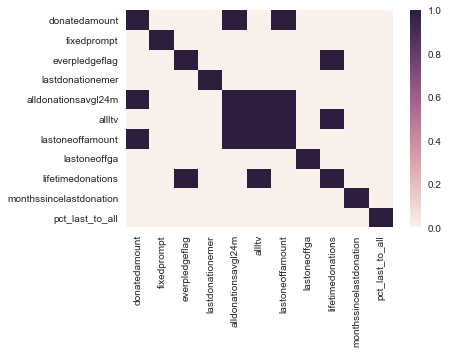

In [157]:
# only showing those with a correlation greater than 0.3 or less than -0.3
sns.heatmap((df.corr()>0.3) | (df.corr()<-3))
df.corr().donatedamount


multi-colinearity in random forest should also be avoided.

Having reviewed the features which have a correlation > 0.3 it shows that the main "conflicts" are between the features which capture a one-off history and "all" donation history.  

I then looked at the correlation between the comparable "all" and "one-off" variables with the donated amount. And this confirms that capturing "all" donations are more correlated:


<img src="correlation.png">

In [4]:
## removing colineated variables
df.drop(df[['monthssincefirstdonation','monthssincelastoneoff','oneoffavgdonatedlast24m',
                                 'oneoffdonationsl24m','oneoffltv','pct_last_to_avg24m']], axis=1, inplace=True)

In [5]:
## create test and training set - 80/20 should be ok as i am also using cross validation.
# df.shape[0]*.2
training_data = df[:1504]
test_data = df[:375]

Mindful mums only populate bins 1 to 4 (up to £40). The second bin (£10-20) is the most common across all profiles.  Unclassified's unsual dist can be explained by the low vol of supporters (6).  WW and RR are more likely to give £100.

### Clustering 

In [5]:
## since my data sample is quite small I would need to be more mindful of sample size if I were creating a classification sample.  
## Should be ok to create 5-10 classifications in the random forest.

from sklearn.cluster import KMeans, AgglomerativeClustering


In [21]:
training_data.head()

,donatedamount,audienceprofile2016,fixedprompt,oneoffavgdonatedlast24m,oneoffdonationsl24m,everpledgeflag,lastdonationemer,alldonationsavgl24m,oneoffltv,allltv,...,mosaic_G,mosaic_H,mosaic_I,mosaic_J,mosaic_K,mosaic_L,mosaic_M,mosaic_N,pct_last_to_avg24m,pct_last_to_all
0,10.0,Upwardly Urban,20.0,8.3333,4.0,0,1,8.7500,64.0,64.0,...,0,0,0,0,0,0,0,0,1.142857,0.156250
1,63.0,Not in target,20.0,25.0000,3.0,0,0,26.6666,700.0,700.0,...,0,1,0,0,0,0,0,0,1.125003,0.042857
2,10.0,Not in target,20.0,0.0000,1.0,1,0,10.2941,15.0,215.0,...,0,0,0,0,0,1,0,0,1.457145,0.069767
3,20.0,Rapid Responders,20.0,30.0000,2.0,0,1,25.0000,517.0,517.0,...,0,0,0,0,0,0,0,0,0.800000,0.038685
4,50.0,Unclassified,20.0,30.0000,4.0,0,1,35.0000,245.0,245.0,...,0,0,0,0,0,0,0,0,1.428571,0.204082


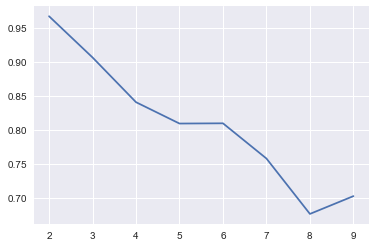

In [91]:
#SILHOUETTE METHOD 
from sklearn.metrics import silhouette_score
# look for max value (which shows greatest separation between the clusters.)
sil_coeff = []
k_values = range(2, 10)
for n_cluster in k_values:
    kmeans = KMeans(n_clusters=n_cluster).fit(training_data[['donatedamount']])
    label = kmeans.labels_
    sil_coeff.append(silhouette_score(training_data[['donatedamount']], label, metric ='manhattan')) # metric='euclidean'
    
plt.plot(k_values,sil_coeff)

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


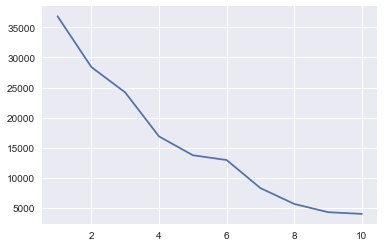

In [131]:
cluster_temp = training_data[['donatedamount']] 
wk_coeff = []

k_values = range(1, 11)

for n_cluster in k_values:
    wkcluster_coeff = []
    kmeans = KMeans(n_clusters=n_cluster).fit(cluster_temp[['donatedamount']])
    cluster_temp['cluster'] = kmeans.labels_
    val = 0

    for e, c in enumerate(kmeans.cluster_centers_): #e is the index, c[0] is the centre donated value for each cluster 
        #sum each observations variance from the mean 
        val += ((cluster_temp[cluster_temp.cluster == e][cluster_temp.columns[0]] - c[0])**2).apply(np.sqrt).sum()
        
    wk_coeff.append(val)

plt.plot(k_values,wk_coeff)

The "elbow" on the above chart isn't very pronounced.  It looks like 4 or 8 might be the optimal number of clusters.  I will use  4 clusters as the 'silhouette' test shows much greater separation at this point vs 8 clusters.

In [23]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(training_data[['donatedamount']])

cluster_temp =training_data[['donatedamount']]
cluster_temp['cluster']=kmeans.labels_

mind = cluster_temp.groupby('cluster').donatedamount.min()
maxd = cluster_temp.groupby('cluster').donatedamount.max()
countd = cluster_temp.groupby('cluster').count()

cluster_df = pd.DataFrame({'mindonation': mind,'maxdonation': maxd})
cluster_df
# # features_df.sort('Importance Score', inplace=True, ascending=False)


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,maxdonation,mindonation
cluster,,
0,37.0,20.0
1,1000.0,1000.0
2,270.0,200.0
3,150.0,80.0
4,500.0,500.0
5,1500.0,1500.0
6,15.0,1.0
7,75.0,40.0


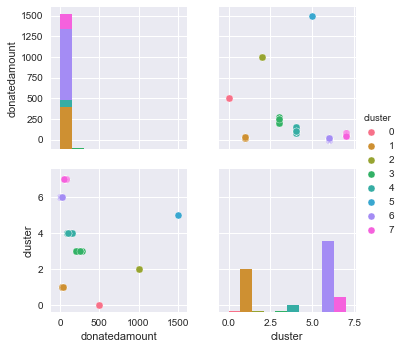

In [150]:
sns.pairplot(data = cluster_temp, hue='cluster')

** Is it right to use a clustering technique?  ** 

The objective of clustering is to identify groups which have separation.  I'm not really interested in that, and actually I might want to create as many donation value classes as possible to create a prediction with less margin for error.  

I think it might be better to create 10 bins up to £100 and £100+?

### Creating bins

In [6]:
##update 19.05.2017, reducing the number of bins, bins between 50 & 90 had too few observations to get good results.
# bins = np.linspace(0, 100, 11) - v1 
bins = np.linspace(0,50, 6) # v2 

def add_bins(x):
#     if np.all(x > bins[10]):
#         return 11 
#     elif np.all(x >bins[9]):
#         return 10 
#     elif np.all(x >bins[8]):
#         return 9 
#     elif np.all(x >bins[7]):
#         return 8 
#     elif np.all(x >bins[6]):
#         return 7 
    if np.all(x >bins[5]):
        return 5 
    elif np.all(x >bins[4]):
        return 4 
    elif np.all(x >bins[3]):
        return 3 
    elif np.all(x >bins[2]):
        return 2 
    elif np.all(x >bins[1]):
        return 1 
    else:
        return 0 
# add the bins to the training and test data sets   
training_data['bin']  = training_data['donatedamount'].map(add_bins)
test_data['bin']  = test_data['donatedamount'].map(add_bins)

# 10, >100 
# 9, 90.01 to 100
# 1, 0 to 10

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [164]:
# Checking the bins by calculating the average donated per bin 
pd.crosstab(training_data.bin,'', values= training_data.donatedamount, aggfunc='mean')
pd.crosstab(training_data.bin,'', values= training_data.donatedamount, aggfunc='max')

bin
0      10.0
1      20.0
2      30.0
3      40.0
4      50.0
5    1500.0
Name: __dummy__, dtype: float64

audienceprofile2016
Mindful Mums            42
Not in target          507
Rapid Responders       321
Unclassified             6
Upwardly Urban         273
Wealthy Wellwishers    355
Name: __dummy__, dtype: int64

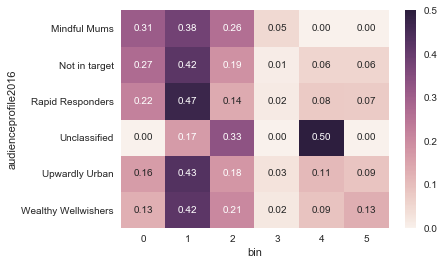

In [159]:
## Does audience profile influence donated amount?

## this shows the distribution across the bins by audience profile.
sns.heatmap(pd.crosstab(training_data.audienceprofile2016, training_data.bin).apply(lambda r: r/r.sum(), axis=1),annot=True, fmt='.2f')
pd.crosstab(training_data.audienceprofile2016,'')

### Decision Tree

Whist an advantage of Decision Trees is that they can take categorical variables as inputs, sklearn can't.  

Rather than creating dummies, which creates 14 nodes in the decision tree, I have created an integer version.  I think in this instance this is ok, as there is an order to the mosaic group, i.e. A is better than B etc.

In [7]:
from sklearn import preprocessing 

#this is creating an integer for each mosaic group
le = preprocessing.LabelEncoder()
le.fit(training_data.mosaicGroup.drop_duplicates())

# and then applying it to the datasets.
training_data['mosaicGroupInt'] = le.transform(training_data.mosaicGroup) 
test_data['mosaicGroupInt'] = le.transform(test_data.mosaicGroup) 


pd.crosstab('',[training_data.mosaicGroup, training_data.mosaicGroupInt])

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


mosaicGroup,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,U
mosaicGroupInt,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
row_0,,,,,,,,,,,,,,,,
,90,299,207,98,218,101,137,63,16,36,24,79,33,53,44,6


In [42]:
training_data.head()

,donatedamount,audienceprofile2016,fixedprompt,everpledgeflag,lastdonationemer,alldonationsavgl24m,allltv,lastoneoffamount,lastoneoffga,lifetimedonations,monthssincelastdonation,mosaicGroup,pct_last_to_all,bin,mosaicGroupInt
0,10.0,Upwardly Urban,20.0,0,1,8.7500,64.0,10.0,1,6.0,66.0,B,0.156250,0,1
1,63.0,Not in target,20.0,0,0,26.6666,700.0,30.0,0,31.0,66.0,H,0.042857,5,7
2,10.0,Not in target,20.0,1,0,10.2941,215.0,15.0,1,21.0,17.0,L,0.069767,0,11
3,20.0,Rapid Responders,20.0,0,1,25.0000,517.0,20.0,0,21.0,14.0,C,0.038685,1,2
4,50.0,Unclassified,20.0,0,1,35.0000,245.0,50.0,1,14.0,14.0,U,0.204082,4,15


In [8]:
## v1 - using all features except for the correlated (removed above), categorical features & invalid predictors.
#dropped audience profile as decision tree didn't want to take strings as an input

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=4)
y_col = 'bin' # 'donatedamount' or 'bin'

X = training_data.copy().dropna() # drops 42 records with nulls
y = X[y_col]

X.drop(['audienceprofile2016','fixedprompt','donatedamount','bin','mosaicGroup'], axis=1, inplace=True)

# Fits the model
model.fit(X, y)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [ ]:
## v2 refined features retrospectively after using feature importance on the random forest models.

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=6)
y_col = 'bin' # 'donatedamount' or 'bin'


x_col = [y_col,'alldonationsavgl24m', 'oneoffltv','oneoffdonationsl24m','oneoffavgdonatedlast24m',
                 'mosaicGroupInt','pct_last_to_all','monthssincelastoneoff']

X = training_data.copy().dropna() # drops 42 records with nulls
y = X[y_col]
X = X[x_col]
X.drop([y_col,'audienceprofile2016','fixedprompt','donatedamount','bin','mosaicGroup'], axis=1, inplace=True)


# Fits the model
model.fit(X, y)

In [8]:
##Building the model from 5 folds to test the accuracy on the training data set

from sklearn.cross_validation import cross_val_score
scores = cross_val_score(model, X,y, scoring = 'accuracy', cv=5)

print(y_col, 'CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))

## nb roc_auc score returns an error when building a multiclass decition tree (auc can only be used for a binary outcome)

donatedamount CV Accuracy [ 0.26031746  0.34653465  0.35763889  0.34767025  0.3465704 ], Average Accuracy 0.3317463301359333


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Update 13/06/2017  
I came back to the analysis and removed the multi-colineated variables which improved the accuracy from 0.489 to 0.514 (averaging the cv folds) and predicting the donated amount bin.

** Visualising the tree ** 

In [147]:
# Helper function to visualize Decision Trees (creates a file tree.png)

from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(model):
    dotfile = open("tree.dot", 'w') # output a file called tree.dot in active directory 
    export_graphviz(model,out_file = dotfile,feature_names = X.columns)
    dotfile.close()
    system("dot -Tpng tree.dot -o tree.png")# this isn't running from python, it is using graphviz to create a png file.
build_tree_image(model)


The above doesn't fully work for me, it produces tree.dot but not the image.

To create the png file, run this from the command line
navigate using **cd** (change directory) to the active directory python is using (the one you're running the notebook from)

**C:\Users\BeckyC\Desktop\Data Science - GA files\Final Project>  
"C:\Program Files (x86)\Graphviz2.38\bin\dot.exe" -Tpng tree.dot -o tree.png**

<img src="tree.png">

The values at each node show the;  
- Rule being applied.  
- The gini shows the precision of the split, values closer to zero show that the rule is better able to distinguish between the different outcomes.  For example if there were 100 samples, and the rule split these in half, then the gini would be 0.5, which shows an inability to split the samples in a way that gets us closer to making an accurate prediction.   
- The sample value is the  number of observations included.  
- The values represent the 6 bins we are trying to predict.  

The original image is saved in the final project folder, opening this you can zoom in and see that as you move from left to right on the leaf nodes (end nodes) the gini increases - this suggests that the tree is better able to classify lower value donations.  This is likely, as the training data set has fewer high value donations to learn from. 

In [98]:
# applying the prediction 
temp = training_data.copy().dropna()
predictions= temp[[y_col]]
predictions = predictions.rename(index=str, columns ={y_col:'Y'})
predictions['y']= model.predict(X)
predictions.head()

,Y,y
0,0,0
1,5,1
2,0,0
3,1,2
4,4,1


In [10]:
# fitting model to unseen test_data 
x_test = test_data.dropna()

test_pred= x_test[[y_col]]
test_pred = test_pred.rename(index=str, columns ={y_col:'Y'})

x_test.drop(['bin', 'donatedamount','fixedprompt','audienceprofile2016','mosaicGroup'],axis=1, inplace=True)

##Applying the prediction 
test_pred['y']=model.predict(x_test)


from sklearn import metrics
print(y_col)
print ('accuracy', metrics.accuracy_score(test_pred.Y, test_pred.y) ) # proportion of correctly made preditions



bin
accuracy 0.524324324324


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


When predicting the **donationamount** (continous) the decision tree is able to predict a third of outcomes correctly, that's 482 of 1462.  When tested on the unseen data, the result is similar; **34% of outcomes are correctly predicted**.

If I use the **bin** (categorical) which classifies donations into £10 buckets the accuracy improves to 49% (mean score from k=5 CV) and a **53% accuracy** on the unseen data.

Does an accuracy around 50%  mean that the prediction is no better than random?  
I think it is better than random because we have 11 classes we're trying to predict (or infinite in the case of the continous donated amount).  I think this means that a random model would predict 1/11th correctly (9%) - pick a number between 1 and 11, you have a 9% chance of getting it right.  Therefore 50% is a significant improvement.  

I also tested reducing the max_depth (aka the number of features), on the training data set reducing the features had little effect, the accuracy remained just above 50%, however on the test set the accuracy deteriorated to 37%.

In [162]:
def _10pct(Y,y):
#     return 1 if  y*0.9 <= Y <=y*1.1 else 0
       
    if y*0.9 <= Y <=y*1.1:
        return True
    else:
        return False
        
pred_10pct =[]
for index, row in test_pred.iterrows():
    pred_10pct.append(_10pct(row['Y'], row['y']))
    
test_pred['pred_10pct'] = pred_10pct

test_pred.groupby('pred_10pct').count()

,Y,y
pred_10pct,,
False,273,273
True,97,97


If I add a +/- 10% buffer to the donated amount prediction, it would only include 4 more true positives.

### Decision Tree feature importance  
nb the order of the tree shows the feature importance.

In [164]:
model.feature_importances_

features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort('Importance Score', inplace=True, ascending=False)

features_df.head()

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Features,Importance Score
4,lastoneoffamount,0.562352
2,alldonationsavgl24m,0.332053
7,monthssincelastdonation,0.083846
8,pct_last_to_all,0.021749
0,everpledgeflag,0.000000


The important features are similar to those highlighted in the regression analysis. Namely, lastoneoffamount explains the current donation amount best. The most important features are those relating to previous giving and not the mosaic classes.  

It looks like **lastoneoffamount and alldonationsavgl24m** could be used without the others, I'll test this, as fewer features will generalise the model which could result in better results on unseen data - update, this lowered the accuracy quite considerably from 50% to 30%.  

On the flip side, I increased the depth to **10 features** and the training accuracy to predict the bin was 47%, and test **accuracy 79%**... this was surprising, why had the test accuracy improved so much?

### Confusion matrix 

correct 194
incorrect 176
total 370
Axes(0.125,0.125;0.62x0.755)


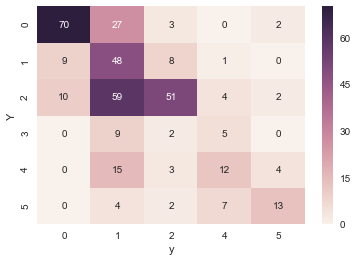

In [11]:
print('correct', test_pred[test_pred.Y== test_pred.y].count().Y) 
print ('incorrect', test_pred[test_pred.Y != test_pred.y].count().Y) 
print ('total', test_pred.count().Y) 

print(sns.heatmap(pd.crosstab(test_pred.Y,  #actual
                              test_pred.y) # prediction
                  ,annot= True))


In [19]:
# Confusion Matrix alternative to the crosstab method above: 
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(test_pred.Y, test_pred.y) 
print(matrix )

# sns.lmplot( 'Y','y', test_pred)

[[70 27  3  0  0  2]
 [ 9 48  8  0  1  0]
 [10 59 51  0  4  2]
 [ 0  9  2  0  5  0]
 [ 0 15  3  0 12  4]
 [ 0  4  2  0  7 13]]


In [18]:
## Classification report (summarises precision, recall and F1 score)
from sklearn.metrics import classification_report

report = classification_report(test_pred.Y, test_pred.y)
print(report)

             precision    recall  f1-score   support

          0       0.79      0.69      0.73       102
          1       0.30      0.73      0.42        66
          2       0.74      0.40      0.52       126
          3       0.00      0.00      0.00        16
          4       0.41      0.35      0.38        34
          5       0.62      0.50      0.55        26

avg / total       0.60      0.52      0.53       370



C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 **Precision** = The models ability to not label a positive sample as negative;  true positives/ total predicted, eg/ the model correctly identified 70 donations in the bin 0, but falsey predicted 19... 70/89 = 0.79  
 
 **Recall** = The models ability to find all positive samples: true positives / total positives, eg/ 70 of a possible 102 were correctly identified as being bin 0.  
 
 **F1-score** = the weighted average of precision and recall (1 best, 0 worst). f = 2* (precision*recall)/ (precision+recall). Known as F1 because precision and recall are evenly weighted (other F scores exist).  
 
 **Support** = the number of positives (actuals) in each bin.

<font color =green> See K047 excel sheet "workings" for analysis on this. </font>  

Commentary based on the Binned model  
The model doesn't predict any values for the 3rd bin (£35-40), this bin contains the least (16) observations.   
The model falsely predicts  a significant number (114) will donate £12-20 (bin1).						
The model is most likely to predict a value between bin1 and bin2, which account for 62%.						
The model is most accurate at identifying those who will donate less than £10 - it only incorrectly associates this donation price with 7% of the sample.						


### Random forests 

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [171]:
## Calculate optimal number of trees... 

#NB X and y set further up the script.
for n_trees in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators = n_trees) # Number of trees to build
    scores = cross_val_score(model, X, y, scoring='accuracy')
    print('n trees: {}, accuracy {}, Average accuracy {}'.format(n_trees, scores, scores.mean()))

n trees: 1, accuracy [ 0.39877301  0.40657084  0.39917695], Average accuracy 0.40150693425219885
n trees: 11, accuracy [ 0.50715746  0.51540041  0.45061728], Average accuracy 0.4910583862803048
n trees: 21, accuracy [ 0.50511247  0.54004107  0.46090535], Average accuracy 0.5020196306645578
n trees: 31, accuracy [ 0.5194274   0.51540041  0.48353909], Average accuracy 0.5061223027302698
n trees: 41, accuracy [ 0.50920245  0.53798768  0.47530864], Average accuracy 0.5074995918781654
n trees: 51, accuracy [ 0.50306748  0.54004107  0.46502058], Average accuracy 0.5027097095186903
n trees: 61, accuracy [ 0.52351738  0.54004107  0.47942387], Average accuracy 0.514327439495884
n trees: 71, accuracy [ 0.52760736  0.55030801  0.46707819], Average accuracy 0.5149978531590513
n trees: 81, accuracy [ 0.53783231  0.52361396  0.47942387], Average accuracy 0.5136233807300725
n trees: 91, accuracy [ 0.52147239  0.5338809   0.46502058], Average accuracy 0.5067912907534946


The above tells me that 51 trees returns the highest accuracy, based on predicting the donatedamount this is **34.7%**.  
Based on predicting the bin 71 trees is optimal with an accuracy of **51%** (nb this is similar to the singular decision tree built further up).

In [172]:
## Picking the optimal depth (number of features)
depths =  range(1,12,1)
for d in depths:
    model = RandomForestClassifier(n_estimators = 50, # Number of trees 
                               oob_score=True,max_depth = d) 
    model.fit(X, y)

    #Cross validation
    scores = cross_val_score(model, X, y,  scoring ='accuracy', cv=5)
    print('max_depth', d)
    print(y_col, 'CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))
    print('oob accuracy score:', model.oob_score_)

max_depth 1
bin CV Accuracy [ 0.4779661   0.51535836  0.50684932  0.43642612  0.51202749], Average Accuracy 0.489725477357115
oob accuracy score: 0.495212038304
max_depth 2
bin CV Accuracy [ 0.50508475  0.51535836  0.53082192  0.51202749  0.51202749], Average Accuracy 0.5150640016327089
oob accuracy score: 0.513679890561
max_depth 3
bin CV Accuracy [ 0.53898305  0.52901024  0.54109589  0.52920962  0.51202749], Average Accuracy 0.5300652587136656
oob accuracy score: 0.52804377565
max_depth 4
bin CV Accuracy [ 0.53559322  0.54948805  0.55136986  0.51546392  0.51202749], Average Accuracy 0.5327885093789796
oob accuracy score: 0.532831737346
max_depth 5
bin CV Accuracy [ 0.53559322  0.55290102  0.55821918  0.51546392  0.52233677], Average Accuracy 0.5369028219194366
oob accuracy score: 0.530779753762
max_depth 6
bin CV Accuracy [ 0.55932203  0.55972696  0.55479452  0.49140893  0.50171821], Average Accuracy 0.5333941329339822
oob accuracy score: 0.534199726402
max_depth 7
bin CV Accuracy [ 

Predicting donatedamount using 50 trees and no max_depth, results in accuracy of **34.59%** (using cv, k=5).  
Reducing **max_depth to 10** (from all 29 features), improved the accuracy to **35.62%**.  
The above suggest the **max depth of 6**, which results in an accuracy of **37.37%**

Predicting the donatedamount **bin** has an accuracy of **53.42%** with a max_depth of 6.


### Feature importance

In [174]:
# Feature importance
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort('Importance Score', inplace=True, ascending=False)

print(features_df.head(10))
print ('y=',y_col, ', number of classes to predict: ', model.n_classes_) 
print('number of features:', model.n_features_)


                  Features  Importance Score
2      alldonationsavgl24m          0.218007
4         lastoneoffamount          0.164715
3                   allltv          0.136630
7  monthssincelastdonation          0.127281
8          pct_last_to_all          0.124801
6        lifetimedonations          0.090004
9           mosaicGroupInt          0.085857
1         lastdonationemer          0.024251
5             lastoneoffga          0.020424
0           everpledgeflag          0.008029
y= bin , number of classes to predict:  6
number of features: 10


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


n_features: 8
row_0
alldonationsavgl24m        1
allltv                     1
lastdonationemer           1
lastoneoffamount           1
lifetimedonations          1
monthssincelastdonation    1
mosaicGroupInt             1
pct_last_to_all            1
lastoneoffga               2
everpledgeflag             3
Name: __dummy__, dtype: int32
Optimal number of features : 8


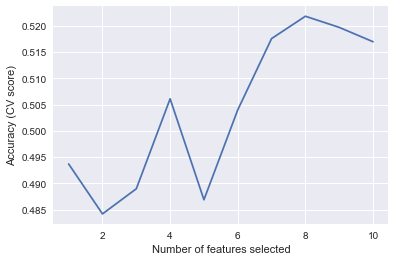

In [175]:
# Recursive feature elimination

# Sklearn provides RFE for recursive feature elimination 
# and RFECV for finding the ranks together with optimal number of features via a cross validation loop.

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
# model = linear_model.LinearRegression()
# X = training_data.ix[0:, 1:] 
# y= training_data['donatedamount']

# while n_features >2:
rfe = RFECV(model, step=1, scoring = 'accuracy',cv= StratifiedKFold(5)) 
rfe = rfe.fit(X, y)

print('n_features:', rfe.n_features_)
print(pd.crosstab(X.columns,'', values=rfe.ranking_, aggfunc='max').sort_values(ascending=True))

print("Optimal number of features : %d" % rfe.n_features_)

# Plot number of features VS. cross-val accuracy score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Accuracy (CV score)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()


Accuracy tends to peak when c.15 features are selected... 

### Final model

In [21]:
## Set X and y, then run each code section below.

y_col = 'bin' # 'donatedamount' or 'bin'
x_col = [y_col,
#          'alldonationsavgl24m', 'oneoffltv','oneoffdonationsl24m','oneoffavgdonatedlast24m','mosaic_M','mosaic_L',
#          'mosaic_I','mosaic_G','mosaic_F' ,'pct_last_to_all','mosaic_D','mosaic_C','mosaic_E','mosaic_A'
#          ,'monthssincelastoneoff']

            'alldonationsavgl24m','allltv','lastdonationemer','lastoneoffamount','lifetimedonations', 
             'monthssincelastdonation', 'mosaicGroupInt','pct_last_to_all']


In [22]:

X = training_data[x_col].dropna()
y = X[y_col]
X.drop([y_col], axis=1, inplace=True)

model = RandomForestClassifier(n_estimators = 70, # Number of trees 
                           oob_score=True,max_depth = 8) 
model.fit(X, y)

#Cross validation
scores = cross_val_score(model, X, y,  scoring ='accuracy', cv=5)
print('predicting',y_col) 
print('CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))
print('oob accuracy score:', model.oob_score_)

predicting bin
CV Accuracy [ 0.54915254  0.54948805  0.55136986  0.50171821  0.50859107], Average Accuracy 0.5320639476689208
oob accuracy score: 0.533515731874


In [23]:
## testing the final model on the unseen data 
X_test = test_data[x_col].dropna()
Y = X_test[y_col]
X_test.drop([y_col], axis=1, inplace=True)

print(y_col)
print ('accuracy', metrics.accuracy_score(Y, model.predict(X_test)) ) # proportion of correctly made preditions
# predictions[predictions.Y== predictions.y]


bin
accuracy 0.651351351351


In [1]:
report = classification_report(Y, model.predict(X_test))
print(report)

NameError: name 'classification_report' is not defined

Commenting on predicting the continuous donatedamount: When predicting donatedamount the accuracy drops significantly on the test set to 26.8% vs the training set 35.4%.  
When predicting the binned donatedamount the accuracy is 54.1% on the training set, which increases to 64.3% on the test set.

370


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


0.33513513513513515

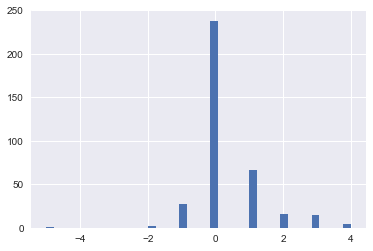

In [180]:
# actual Y minus predicted y for **donatedamount**
residuals = (Y -model.predict(X_test))
plt.figure()
plt.hist(residuals, bins=np.ceil(np.sqrt(len(y))))
print(len(X_test))

(Y -model.predict(X_test)).mean()

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


(array([   1.,    0.,    1.,    0.,    0.,    2.,    0.,    0.,    1.,
           0.,    0.,   10.,  136.,   76.,   82.,    7.,   14.,   25.,
           1.,    4.,    0.,    0.,    0.,    1.,    5.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,
           0.,    0.,    1.]),
 array([ -90.        ,  -82.94871795,  -75.8974359 ,  -68.84615385,
         -61.79487179,  -54.74358974,  -47.69230769,  -40.64102564,
         -33.58974359,  -26.53846154,  -19.48717949,  -12.43589744,
          -5.38461538,    1.66666667,    8.71794872,   15.76923077,
          22.82051282,   29.87179487,   36.92307692,   43.97435897,
          51.02564103,   58.07692308,   65.12820513,   72.17948718,
          79.23076923,   86.28205128,   93.33333333,  100.38461538,
         107.43589744,  114.48717949,  121.53846154,  128.58974359,
         135.64102564,  142.69230769,  149.74358974,  156.79487179,
         163.84615385,  170.8974359 ,  177.94871795,  185.        ]),
 <a

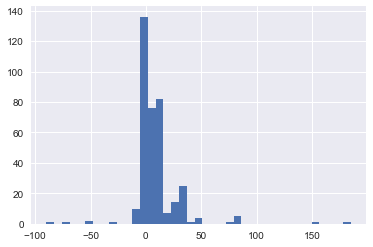

In [70]:
# Residuals with the outliers removed - deleted residuals at £900 and £850

# residuals[residuals==900]
# residuals.drop(148, axis=0, inplace=True)

plt.figure()
plt.hist(residuals, bins=np.ceil(np.sqrt(len(y))))
residuals.groupby(residuals).count()

370


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


0.33513513513513515

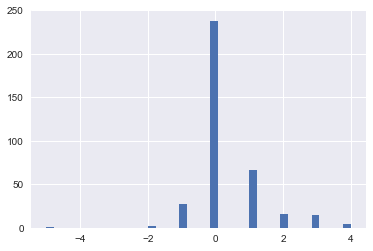

In [181]:
# actual Y minus predicted y for **binned donatedamount**
residuals = (Y -model.predict(X_test))
plt.figure()
plt.hist(residuals, bins=np.ceil(np.sqrt(len(y))))
print(len(X_test))
(Y -model.predict(X_test)).mean()

At first it appears like the binned model has a wider residual spread, however the axis is deceiving as outlier values are  highlighted on a more concise axis.  
The mean residual error on the donatedamount model (£13.72) isn't comparable with the mean residual error on the binned model (0.83)- this suggests 0.83 of £10 plus value of the £100+ bin. 

pred_bin   0   1   2  3   4   5
bin                            
0         77  23   1  0   0   1
1          3  62   1  0   0   0
2          7  56  62  0   1   0
3          0   6   7  2   1   0
4          0  11   3  0  18   2
5          0   4   4  0   1  17


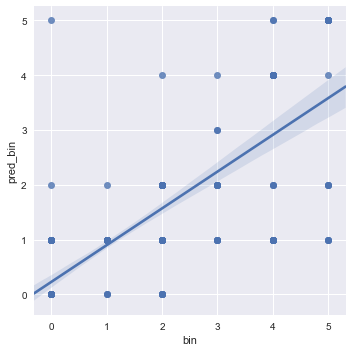

In [199]:
#  model.predict(X_test)
predictions = pd.DataFrame(Y) 
predictions['pred_bin']  = model.predict(X_test)
predictions.head()

sns.lmplot( 'bin','pred_bin', predictions)
print(pd.crosstab(predictions.bin, predictions.pred_bin))

### Feedback 

Colin Crawford
Nice work/process and understanding. Very clear layout.

Pandas has an inbuilt function (pd.cut) which can create bins for you, although it is based on the distribution of the data so not as clean.

What could be useful with the clustering is being able to forecast what characteristics a new donated will be based on their similarities to other people within their cluster, this would allow you to target them appropriately and forecast their giving.

You are correct when comparing your accuracy with the base. You should also look at some other other metrics and have a think about whether they would be useful. **A confusion matrix would help you to understand where you errors are.(are you mistaking a £90 for a £100 or for a £10?)**

<font color=red> What does this mean? </font>When it comes to estimators, don’t be scared to go higher especially if your grid search returns a result on one of your bounds. Estimators tend to usually lie between 100-1000 or even higher, but at some point it will start to overfit. 

Updated after the course; To assess whether the random forest performed better or worse than the earlier linear regression model, I converted the linear model output into a confusion matrix, which allows me to compare the two models;

<img src="linear regression confusion matrix.png">

I could then compare the residuals... 

<img src="Residuals.png">

Which shows that the random forest model is more centred around zero (less error).   
A negative residual occurs when the prediction is bigger than the actual donation bin. This occurs 91 times in the regression model, and is arguably the more dangerous error that may deter a supporter from giving.